# 1. Lý thuyết

1)  Đặc diểm của kiến trúc RNN là gì ?

Đáp án:


C. RNN là kiến trúc dự báo có tính thứ tự và tính truy hồi. Các dự báo được thực hiện theo tuần tự thời gian và output của các step trước được sử dụng như input của step hiện tại.


2) Nhận định nào sau đây là đúng về RNN?

Đáp án:


D. Kiến trúc RNN chia sẻ tham số trên toàn bộ các units nên số lượng tham số không phụ thuộc vào độ dài văn bản.

3) Để huấn luyện mạng RNN thì một chú ý quan trọng tại time step t=0 chúng ta cần làm gì ?

Đáp án:


D. Khởi tạo ngẫu nhiên một véc tơ kích hoạt $a^{<0>}$ như một giá trị có tác dụng kích hoạt tính toán.

4) Sự khác biệt giữa RNN và CNN là gì?

Đáp án:

A. RNN là kiến trúc truy hồi có thể trả ra kết quả dự báo ở nhiều timestep. CNN không có khả năng truy hồi để dự báo theo timestep


5) Véc tơ context trong kiến trúc LSTM và GRU có tác dụng gì ?

Đáp án:


B. Ghi nhận bối cảnh xuyên suốt toàn bộ chuỗi tính đến thời điểm hiện tại



# 2. Thực hành


6. Từ bộ dữ liệu [Sentiment-analysis-on-movie-reviews](https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data) hãy sử dụng các thuật toán trong RNN để huấn luyện mô hình phân loại cảm xúc văn bản. (1 điểm)

7. Sử dụng mô hình LSTM để dự báo tổng số lượng khách hàng sử dụng dịch vụ hàng không [air- passengers](https://www.kaggle.com/datasets/rakannimer/air-passengers) (2 điểm)

8. Xây dựng một mô hình thêm dấu Tiếng Việt sử dụng LSTM. Cách xử lý để tạo bộ dữ liệu có thể tham khảo tại [them dau tieng viet](https://phamdinhkhanh.github.io/2020/05/28/TransformerThemDauTV.html#1-d%E1%BB%AF-li%E1%BB%87u). (2 điểm)



##6. Từ bộ dữ liệu [Sentiment-analysis-on-movie-reviews](https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data) hãy sử dụng các thuật toán trong RNN để huấn luyện mô hình phân loại cảm xúc văn bản. (1 điểm)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import time
import string

import numpy as np 
import pandas as pd 

import torch
import torch.nn as nn
from torchtext.legacy import data
import torch.optim as optim
from torchtext.vocab import Vectors
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [ ]:
os.chdir("/content/drive/MyDrive/DL/10.LSTM_Homework_HauTran")

In [ ]:
def load_data(file_path, device):
    tokenizer = lambda x: str(x).translate(str.maketrans('', '', string.punctuation)).strip().split()
    TEXT = data.Field(sequential=True, lower=True, include_lengths=True, tokenize=tokenizer)
    LABEL = data.Field(sequential=False, use_vocab=False)
    
    trn_dataField = [('PhraseId', None), ('SentenceId', None), ('Phrase', TEXT), ('Sentiment', LABEL)]
    tst_dataField = [('PhraseId', None), ('SentenceId', None), ('Phrase', TEXT)]
    
    train = data.TabularDataset(path=os.path.join(file_path, 'train.tsv'), format='tsv', skip_header=True, fields=trn_dataField)
    test = data.TabularDataset(path=os.path.join(file_path, 'test.tsv'), format='tsv', skip_header=True, fields=tst_dataField)
    
    train, valid = train.split(random_state=random.seed(1234))
    cache = ('/content/drive/MyDrive/DL/data/sentiment-analysis-on-movie-reviews/.vector_cache')
    if not os.path.exists(cache):
        os.mkdir(cache)
    # using the pretrained word embedding.
    vector = Vectors(name='/content/drive/MyDrive/DL/data/sentiment-analysis-on-movie-reviews/glove.6B.100d.txt', cache=cache)
    TEXT.build_vocab(train, vectors=vector, unk_init=torch.Tensor.normal_)
    
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train, valid, test), device=device, batch_size=64, 
                                                       sort_key=lambda x:len(x.Phrase), sort_within_batch=True)
    return TEXT, LABEL, train_iter, valid_iter, test_iter


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TEXT, LABEL, train_iter, valid_iter, test_iter = load_data('/content/drive/MyDrive/DL/data/sentiment-analysis-on-movie-reviews', device)

In [ ]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=pad_idx)
        
        self.rnn = nn.LSTM(embedding_size, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        if bidirectional:
            self.fc = nn.Linear(2 * hidden_dim, output_dim)
        else:
            self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text, lengths):
        
        embedded = self.embedding(text)   #embedded : [sen_len, batch_size, emb_dim]
        
        packed_embedded = pack_padded_sequence(embedded, lengths)
        
        # packed_output : [num_word, emb_dim]     hidden : [num_layers * num_direction, batch_size, hid_dim]    
        # cell : [num_layers * num_direction, batch_size, hid_dim]
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        output, output_length = pad_packed_sequence(packed_output)
        
        hidden = self.dropout(torch.cat([hidden[-2,:,:], hidden[-1,:,:]], dim=1)).squeeze()
         # hidden : [batch_size, hid_dim * num_dir]
        return self.fc(hidden)
    
    
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = SentimentModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,950,309 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def accuracy(preds, y):
    '''
    Return accuracy per batch ..
    '''
    preds = torch.argmax(torch.softmax(preds, dim=1), dim=1)
    correct = (preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time  / 60)
    elapsed_secs = int(elapsed_time -  (elapsed_mins * 60))
    return  elapsed_mins, elapsed_secs

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for i, batch in enumerate(iterator):
        
        text, text_lengths = batch.Phrase
        if(torch.min(text_lengths) <= 0): 
            continue

        predictions = model(text, text_lengths)
        
        loss = criterion(predictions, batch.Sentiment)
        
        acc = accuracy(predictions, batch.Sentiment)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        if i % 100 == 99:
            print(f"[{i}/{len(iterator)}] : epoch_acc: {epoch_acc / len(iterator):.2f}")
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            
            text, text_lengths = batch.Phrase
            
            if(torch.min(text_lengths) <= 0): 
#                 continue
                predictions = torch.Tensor([[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],
                                           [0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],
                                           [0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],
                                           [0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],
                                           [0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],
                                           [0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],
                                           [0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],
                                           [0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],
                                           [0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],
                                           [0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],
                                           [0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],
                                           [0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],
                                           [0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],
                                           [0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],
                                           [0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],
                                           [0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0]]).to(device)
            else:
                predictions = model(text, text_lengths)
            
            loss = criterion(predictions, batch.Sentiment)
        
            acc = accuracy(predictions, batch.Sentiment)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator),  epoch_acc / len(iterator)

In [ ]:
N_epoches = 10

trainLossRecords = []
validLossRecords = []

best_valid_loss = float('inf')

for epoch in range(N_epoches):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    # get the loss records to visualize.
    trainLossRecords.append(train_loss)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion)
    validLossRecords.append(valid_loss)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if train_loss < best_valid_loss:
        best_valid_loss = train_loss
        torch.save(model.state_dict(), 'Sentiment-model.pt')
        
    print(f'Epoch:  {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain  Loss: {train_loss: .3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValid  Loss: {valid_loss: .3f} | Valid Acc: {valid_acc*100:.2f}%')

[99/1707] : epoch_acc: 0.03
[299/1707] : epoch_acc: 0.09
[399/1707] : epoch_acc: 0.12
[499/1707] : epoch_acc: 0.15
[599/1707] : epoch_acc: 0.18
[699/1707] : epoch_acc: 0.21
[799/1707] : epoch_acc: 0.25
[899/1707] : epoch_acc: 0.28
[999/1707] : epoch_acc: 0.31
[1099/1707] : epoch_acc: 0.35
[1199/1707] : epoch_acc: 0.38
[1299/1707] : epoch_acc: 0.42
[1399/1707] : epoch_acc: 0.45
[1499/1707] : epoch_acc: 0.49
[1599/1707] : epoch_acc: 0.52
[1699/1707] : epoch_acc: 0.56
Epoch:  01 | Epoch Time: 7m 56s
	Train  Loss:  1.084 | Train Acc: 55.92%
	Valid  Loss:  0.955 | Valid Acc: 61.46%
[99/1707] : epoch_acc: 0.04
[199/1707] : epoch_acc: 0.07
[299/1707] : epoch_acc: 0.11
[399/1707] : epoch_acc: 0.15
[499/1707] : epoch_acc: 0.19
[599/1707] : epoch_acc: 0.22
[699/1707] : epoch_acc: 0.26
[799/1707] : epoch_acc: 0.30
[899/1707] : epoch_acc: 0.34
[999/1707] : epoch_acc: 0.37
[1099/1707] : epoch_acc: 0.41
[1199/1707] : epoch_acc: 0.45
[1299/1707] : epoch_acc: 0.49
[1399/1707] : epoch_acc: 0.52
[1499/1

##7. Sử dụng mô hình LSTM để dự báo tổng số lượng khách hàng sử dụng dịch vụ hàng không [air- passengers](https://www.kaggle.com/datasets/rakannimer/air-passengers) (2 điểm)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.models import Sequential

import os

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DL/data/AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
data.columns = ['Date', 'Passengers']
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m')
data = data.set_index('Date')
data.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


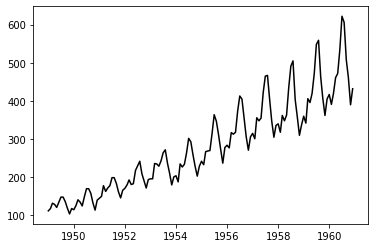

In [ ]:
plt.plot(data, color='black')
plt.show()

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
data['Passengers'] = scaler.fit_transform(data['Passengers'].values.reshape(-1,1))
data.head()

,Passengers
Date,
1949-01-01,0.015444
1949-02-01,0.027027
1949-03-01,0.054054
1949-04-01,0.048263
1949-05-01,0.032819


In [ ]:
def load_data(data, seq_len):
    x = []
    y = []
    for i in range(seq_len, len(data)):
        x.append(data.iloc[i-seq_len : i, 0])
        y.append(data.iloc[i, 0])
    return x,y

In [ ]:
x, y = load_data(data, 20)
num = int(len(data['Passengers'])*0.8)

In [ ]:
x_train = x[:num]
y_train = y[:num]
x_test = x[num:]
y_test = y[num:]

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
x_train = np.reshape(x_train, (num, 20, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 20, 1))

In [ ]:
lstmModel = Sequential()
lstmModel.add(LSTM(100, activation="ReLU", return_sequences=True, input_shape=(x_train.shape[1], 1)))
lstmModel.add(Dropout(0.2))
lstmModel.add(LSTM(80, activation="ReLU", return_sequences=True))
lstmModel.add(Dropout(0.2))
lstmModel.add(LSTM(50, activation="ReLU", return_sequences=True))
lstmModel.add(Dropout(0.2))
lstmModel.add(LSTM(30, activation="ReLU"))
lstmModel.add(Dense(1))
lstmModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 20, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 80)            57920     
                                                                 
 dropout_1 (Dropout)         (None, 20, 80)            0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 50)            26200     
                                                                 
 dropout_2 (Dropout)         (None, 20, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 30)                9

In [ ]:
lstmModel.compile(optimizer="adam", loss="MSE")
lstmModel.fit(x_train, y_train, epochs=15, batch_size=50)

Epoch 1/15
3/3 [==============================] - 6s 64ms/step - loss: 0.1578
Epoch 2/15
3/3 [==============================] - 0s 59ms/step - loss: 0.1328
Epoch 3/15
3/3 [==============================] - 0s 58ms/step - loss: 0.0946
Epoch 4/15
3/3 [==============================] - 0s 57ms/step - loss: 0.0380
Epoch 5/15
3/3 [==============================] - 0s 61ms/step - loss: 0.0341
Epoch 6/15
3/3 [==============================] - 0s 66ms/step - loss: 0.0192
Epoch 7/15
3/3 [==============================] - 0s 58ms/step - loss: 0.0202
Epoch 8/15
3/3 [==============================] - 0s 57ms/step - loss: 0.0255
Epoch 9/15
3/3 [==============================] - 0s 57ms/step - loss: 0.0208
Epoch 10/15
3/3 [==============================] - 0s 56ms/step - loss: 0.0139
Epoch 11/15
3/3 [==============================] - 0s 60ms/step - loss: 0.0145
Epoch 12/15
3/3 [==============================] - 0s 57ms/step - loss: 0.0137
Epoch 13/15
3/3 [==============================] - 0s 61ms/st

##8. Xây dựng một mô hình thêm dấu Tiếng Việt sử dụng LSTM. Cách xử lý để tạo bộ dữ liệu có thể tham khảo tại [them dau tieng viet](https://phamdinhkhanh.github.io/2020/05/28/TransformerThemDauTV.html#1-d%E1%BB%AF-li%E1%BB%87u). (2 điểm)